# Tutorial : Computing with triangular shapes in Kendall framework

Lead author: Elodie Maignant.

David G. Kendall first took interest into triangular shapes while studying random alignments of points in archeology and related fields [[KK1980]](#References). Following this statistical study, he developped the more general theory of shapes. This theory echoes in many fields like biology, medicine, or image analysis, where the shape of an object is particularly relevant when it comes to its analysis. Since the deformation of a shape is not necessarely linear, we need to use geometric statistics in order to proceed with such data.

In Kendall theory, the word shape is used in the common sense, refering to the appearance of an object. Since the shape of an object should not depend on the way it is looked at or computed, it is natural to remove location, rotationnal and eventually scale effects. A practical way of describing an object's shape is to locate a finite number of relevant points on it, which we call landmarks, which should summarize the geometrical and/or scientifical information [[DM2016]](#References). 

Thus we define Kendall shape space of order $(k,m)$ (where $k\geq 2$) as the quotient of $k$-tuples of non-aligned points in $\mathbb{R}^m$ by the group of rotations, translations and dilatations of $\mathbb{R}^m$ :  

$$\big(\Sigma^k_m\triangleq\mathbb{R}^{km}\setminus \Delta \big)/\big(\mathbb{R_+^*}\times SO(m)\ltimes \mathbb{R}^m\big)$$

where $\Delta =\{\ (a)_{1\leq i\leq k}\ |\ a\in\mathbb{R}^m\}$ correspond to the degenerate case where all landmarks collapse into a unique point.

It is useful to see that considering first the action of translations and dilatations before applying rotation group $\text{SO}$ allows to write :

$$\Sigma^k_m=\mathcal{S}^k_m/ \text{SO}(m)$$

where $\mathcal{S}^k_m$, called the pre-shape space of order $(k,m)$ denotes the space of centered and normalized $k$-tuples of in $\mathbb{R}^m$. It corresponds to the unit sphere of dimension $k(m-1)$ [[K1984]](#References).

The Kendall shape space of order $(k,m)$ is a differential manifold which acquires singularities as soon as $m\geq 3$. Apart from these singularities, it is a smooth manifold which can be equipped with a Riemannian metric inherited from the Frobenius metric on the pre-shape space [[LK1993]](#References). 

In this tutorial, we take a deeper look at two specific cases of Kendall shape spaces : the space $\Sigma^3_2$ of 2D triangles and the space $\Sigma^3_3$ of 3D triangles. These two spaces are particularly interesting to look at because there exists a projection such that we can directly visualize them.

The tutorial is organized as follows :

- First, we present the case of 2D triangles, and illustrate some geometric tools with a dedicated visualization class.
- Then, following the same scheme, we look at the 3D case.
- Finally, we explore these visualizations with the dataset of the optical nerves head

# Set up 

In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import KendallShapeMetric, PreShapeSpace
from geomstats.visualization import KendallDisk, KendallSphere

INFO: Using numpy backend


# The space $\Sigma_2^3$ of 2D triangles

In [3]:
m_ambient = 2
k_landmarks = 3
preshape_triangle_2d = PreShapeSpace(3, 2)
metric_triangle_2d = KendallShapeMetric(3, 2)

The space $\Sigma_2^3$ of 2D triangles is a manifold of dimension $2=3\times(2-1)-1$. Kendall showed that it is isometric to the $2$-sphere of radius $1/2$ [[K1984]](#References). Such an isometry can be computed explicitly. Practically, this means that 2D triangular shape datasets can be directly visualized in 3D without losing any information (especially geometrical ones). Furthermore, all geometric statistics can be directly processed on the sphere, for which we already have a large catalogue of explicit methods.

 First step consist in projecting (via the isometry mentionned above) the triangles on the sphere. In order to visualize better how the space $\Sigma_2^3$ is mapped onto the sphere $S^2(1/2)$, we plot regularly sampled triangles at their corresponding location (according to the projection).

In [4]:
S = KendallSphere()

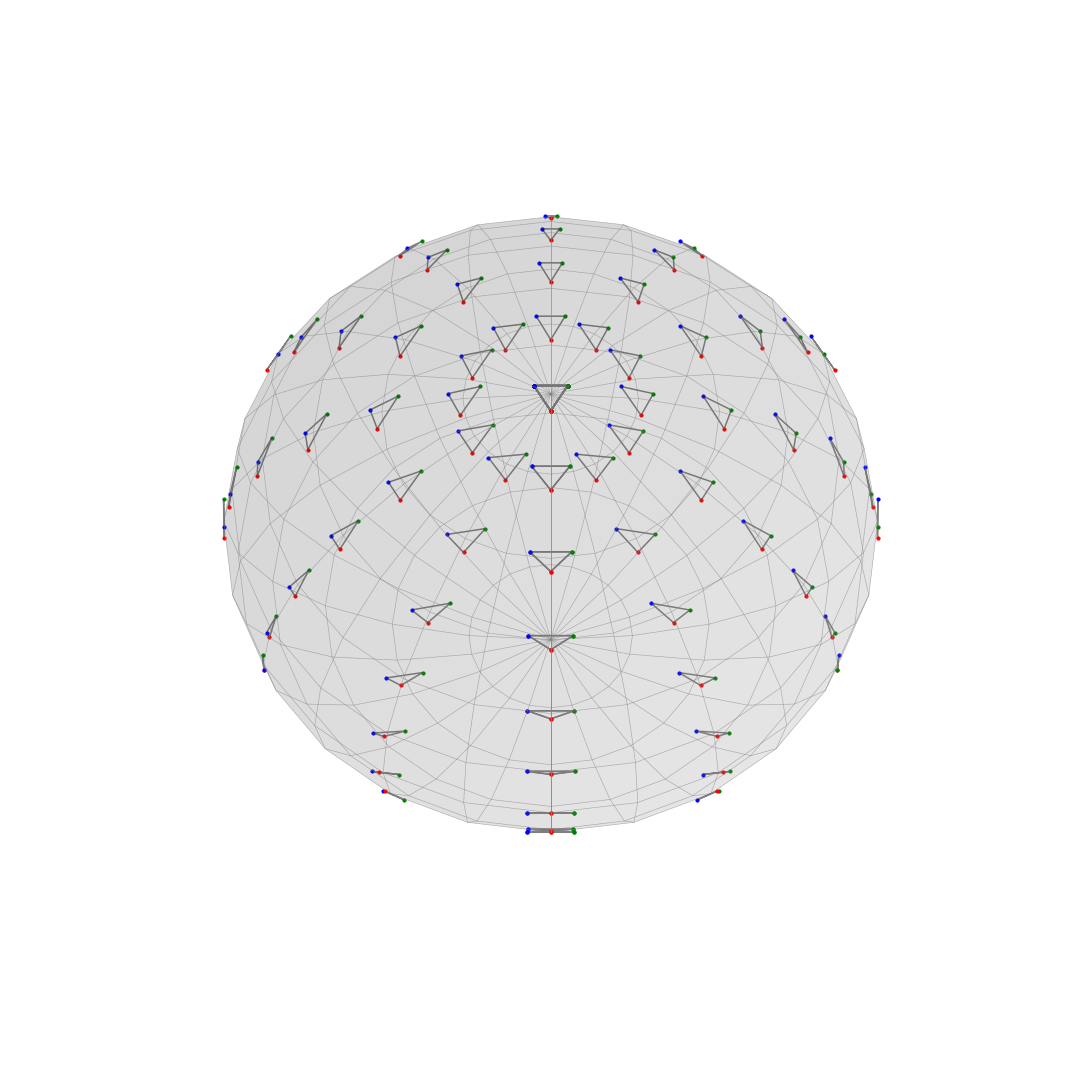

In [5]:
fig = plt.figure(figsize=(15, 15))
S.draw()

One can easily notice that the equator corresponds to flat triangles while first meridian is paired with the subset of isocele triangles whose apex is red.

We now illustrate how some essential statistic and geometric tools project on the sphere.

## Uniform distribution 

Since the projection is isometric, the uniform distribution in $\Sigma^3_2$ is exactly the uniform distribution on the sphere.

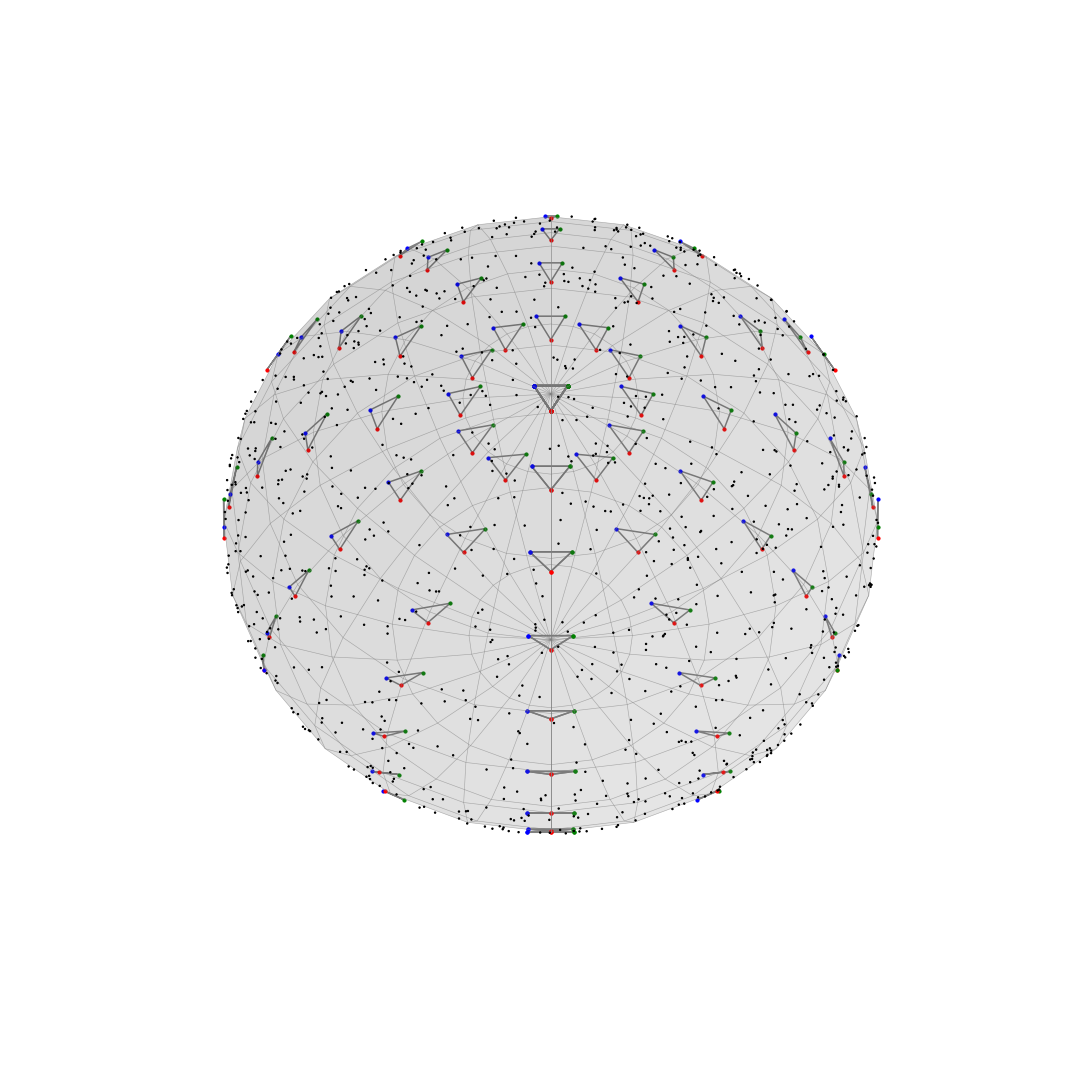

In [6]:
fig = plt.figure(figsize=(15, 15))
S.draw()

points = preshape_triangle_2d.random_uniform(1000)

S.clear_points()
S.add_points(points)
S.draw_points(color='k', s=2)

## Geodesic 

The geodesics in $\Sigma^3_2$ corresponds to great circles on the sphere. The distance between two triangles of $\Sigma^3_2$ is given exactly by the arc-length of the arc joining the two projected points on the sphere. The diameter of the space $\Sigma^3_2$, defined as the distance between the two most distant points, is then equal to $\pi/2$.

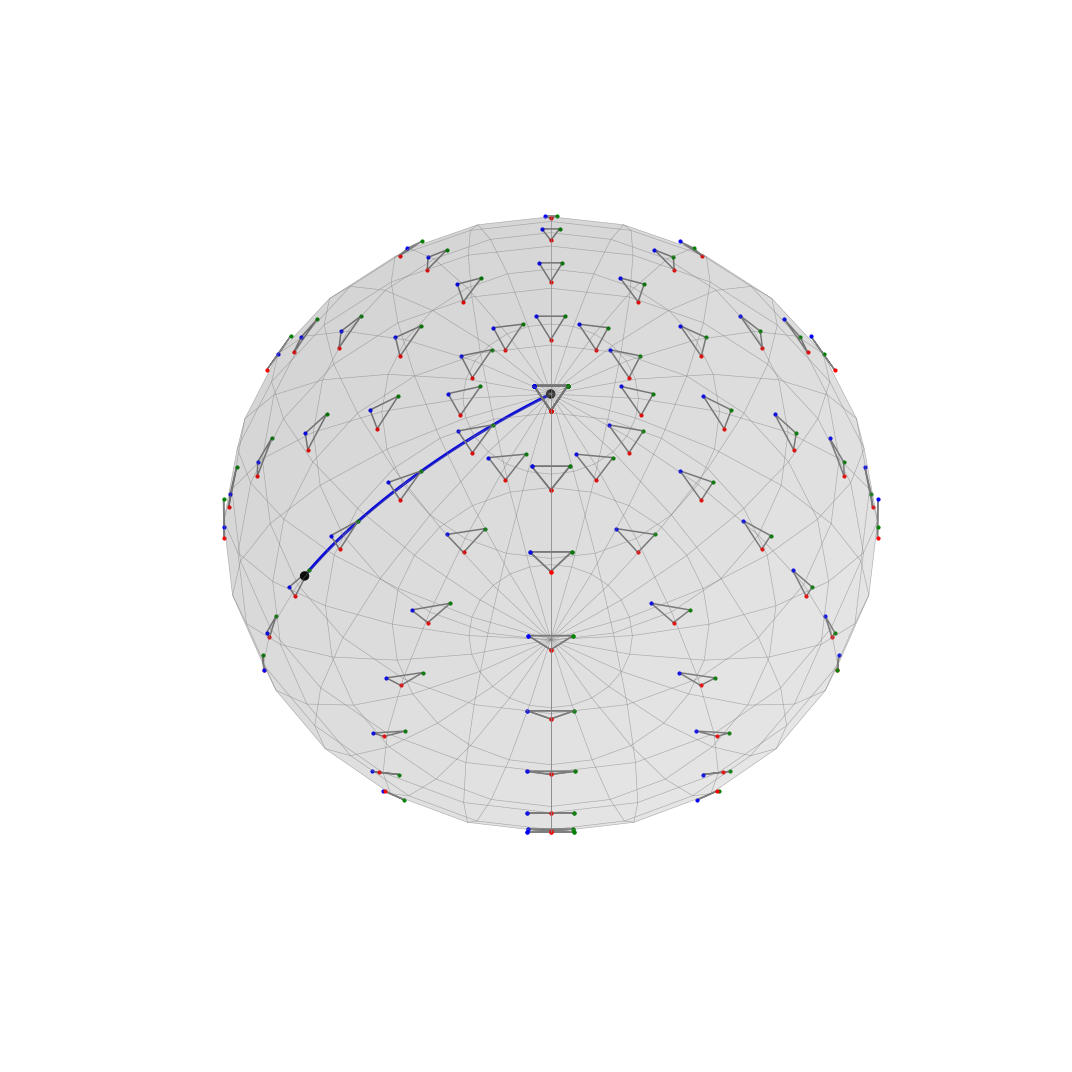

In [7]:
fig = plt.figure(figsize=(15, 15))
S.draw()

times = gs.linspace(0., 1., 1000)
velocities = gs.array([-t * .5 * S.ub for t in times])
points = metric_triangle_2d.exp(velocities, S.pole)

S.clear_points()
S.add_points(points)
S.draw_curve(color='b', lw=3)
S.clear_points()
S.add_points(points[[0, -1]])
S.draw_points(color='k', s=70)

## Parallel transport 

Given the geodesics and the logarithm map, one can easily compute the parallel transport of a vector $w$ along the geodesic $\exp_\text{b.p.}(tv)$ using the Pole Ladder algorithm implemented in geomstats.

In [8]:
base_point, v, w = S.pole, -.5 * S.ub, S.ua
n_rungs=10
ladder = metric_triangle_2d.ladder_parallel_transport(
    w, v, base_point, n_rungs, return_geodesics=True)

transported = ladder['transported_tangent_vec']
end_point = ladder['end_point']
trajectory = ladder['trajectory']

n_points = 10
t = gs.linspace(0., 1., n_points)
t_main = gs.linspace(0., 1., n_points * 4)
main = []
diag = []
for points in trajectory:
    main_geodesic, diagonal, final_geodesic = points
    main.append(main_geodesic(t_main))
    diag.append(diagonal(-t))
    diag.append(diagonal(t))

diag = gs.stack(diag).reshape(-1, k_landmarks, m_ambient)
main = gs.stack(main).reshape(-1, k_landmarks, m_ambient)

tangent_vectors = [v / n_rungs, w / n_rungs, transported / n_rungs]
base_points = [base_point, base_point, main[-1]]

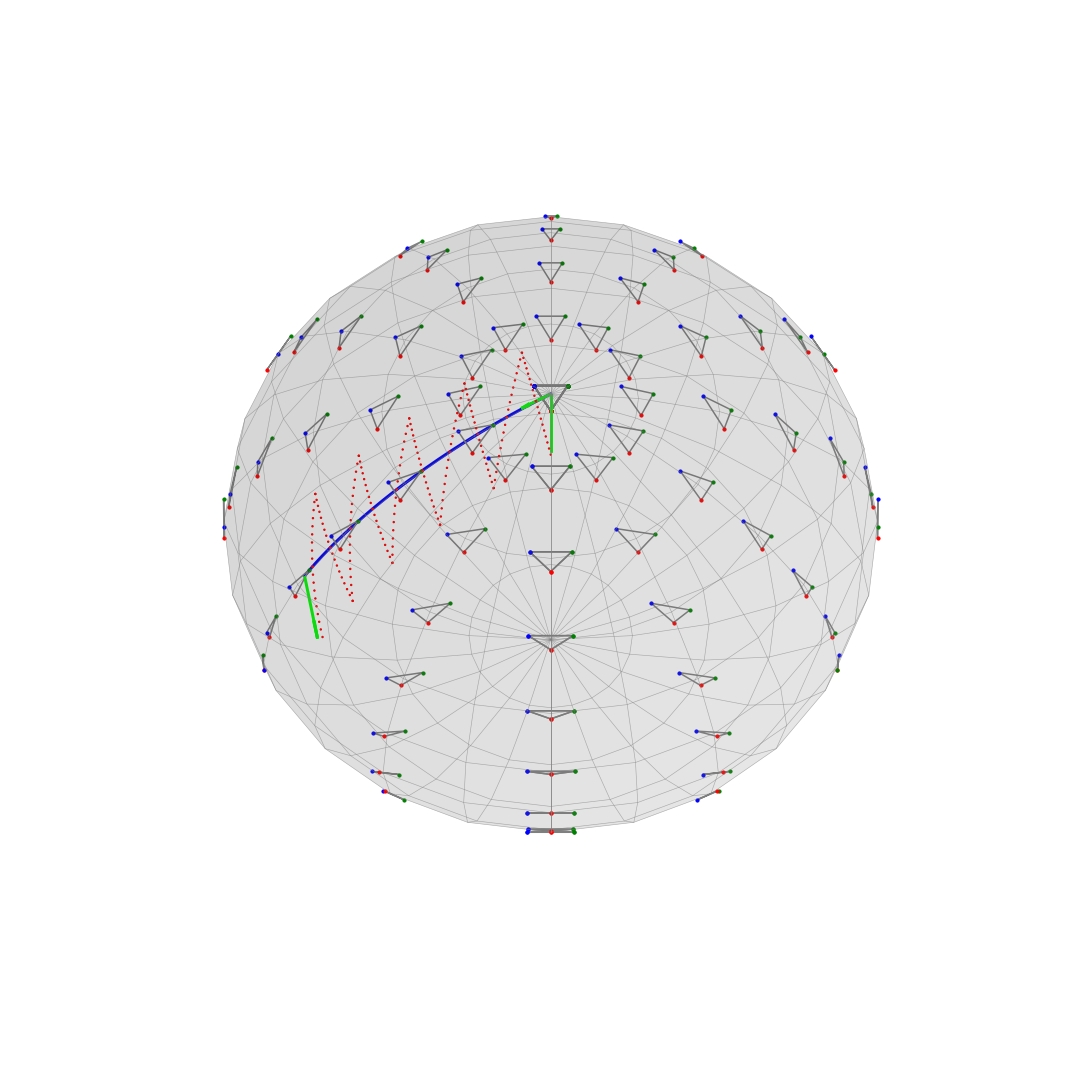

In [9]:
fig = plt.figure(figsize=(15, 15))
S.draw()

S.clear_points()
S.add_points(main)
S.draw_curve(color='b', lw=3)
S.clear_points()
S.add_points(diag)
S.draw_points(color='r', s=2)
for bp, tv in zip(base_points, tangent_vectors):
    S.draw_vector(tv, bp, color=(0,1,0), lw=3)

The diagonal geodesics used by the Pole Ladder method to compute the parallel transport are plotted in red.

In the specific case of Kendall shape spaces, one can use a second method, based on an integration scheme. This method follows the result of [[KDLS2021]](#References) giving conditions on a vector field in the top space $\mathcal S^k_m$ for its projection to be the parallel transport in the shape space $\Sigma^k_m$. The implementation of the method can be found in the [KendallShapeMetric](https://github.com/geomstats/geomstats/blob/f9f669551faeaf8c23f347b57d1ce3970eacbe3a/geomstats/geometry/pre_shape.py#L569) and is described along with its comparison to the Pole Ladder method in [[GMTP21]](#References).

# The space $\Sigma_3^3$ of 3D triangles

In [10]:
m_ambient = 3
k_landmarks = 3
preshape_triangle_3d = PreShapeSpace(3, 3)
metric_triangle_3d = KendallShapeMetric(3, 3)

Once we know that $\Sigma^3_2$ is isometric to the $2$-shere of radius $1/2$, it follows that the space $\Sigma_3^3$ of 3D triangles is then isometric to the $1$-ball of radius $\pi/4$. More generally, for $m\geq k$, the space $\Sigma^k_m$ is isometric to the quotient $\Sigma^k_{k-1}/\mathbb{Z}_2$ [[LK1993]](#References).

In [11]:
D = KendallDisk()

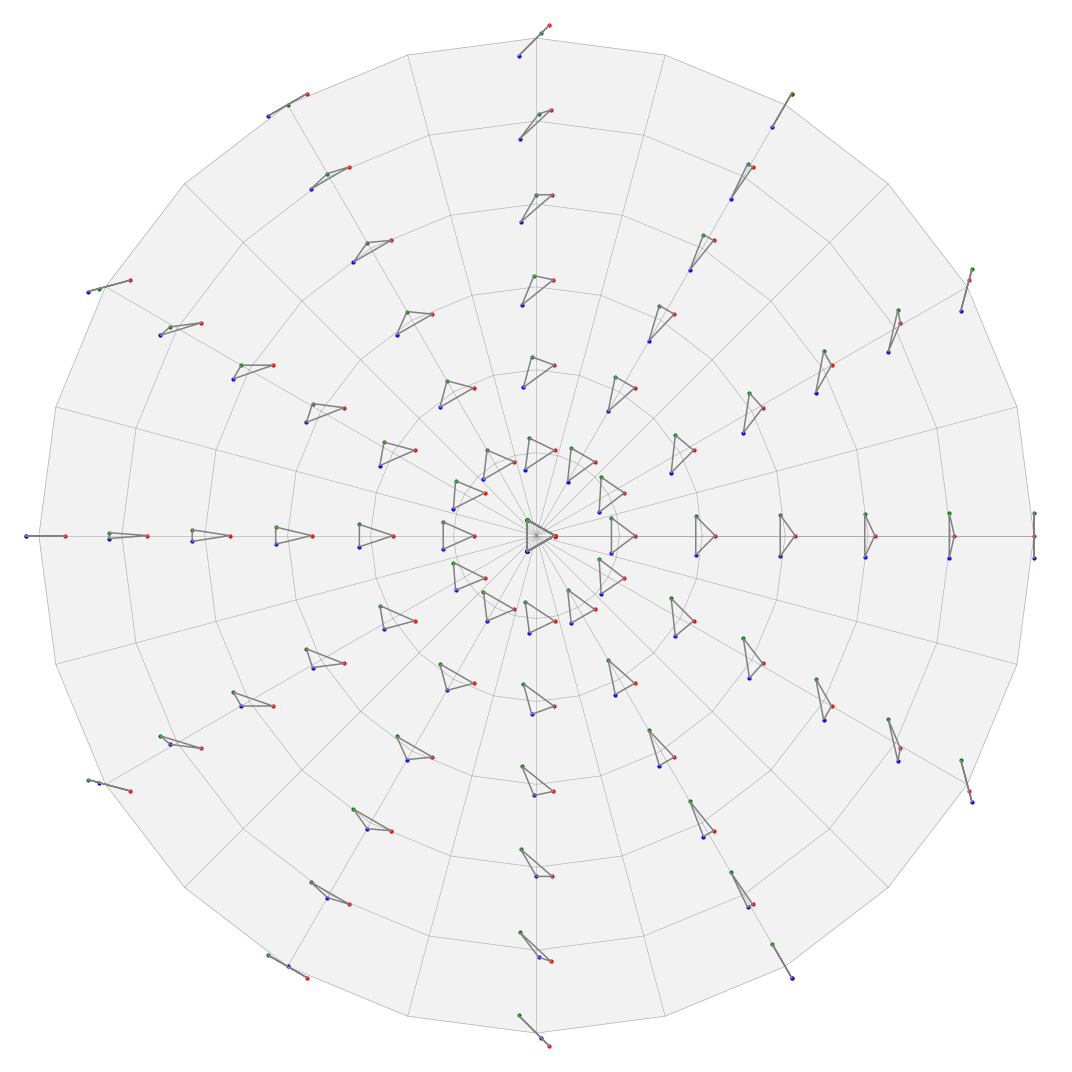

In [12]:
fig = plt.figure(figsize=(15, 15))
D.draw()

The shape space $\Sigma_3^3$ is a manifold with boundary, which coincides with its singularity. We see on the above figure that it corresponds to set of flat triangles, which was located on the equator in the case of $\Sigma^3_2$.

In [13]:
flat = gs.array([[0., 0., 0.], 
                 [1., 0., 0.], 
                 [-1., 0., 0.]])/gs.sqrt(2.)

preshape_triangle_3d.align(flat, D.centre)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.89809642e-18,  7.07106781e-01,  0.00000000e+00],
       [-8.89809642e-18, -7.07106781e-01,  0.00000000e+00]])

## Uniform distribution 

As in the previous example, the uniform distribution on $\Sigma^3_3$ is given exactly by the uniform distribution on a disk.

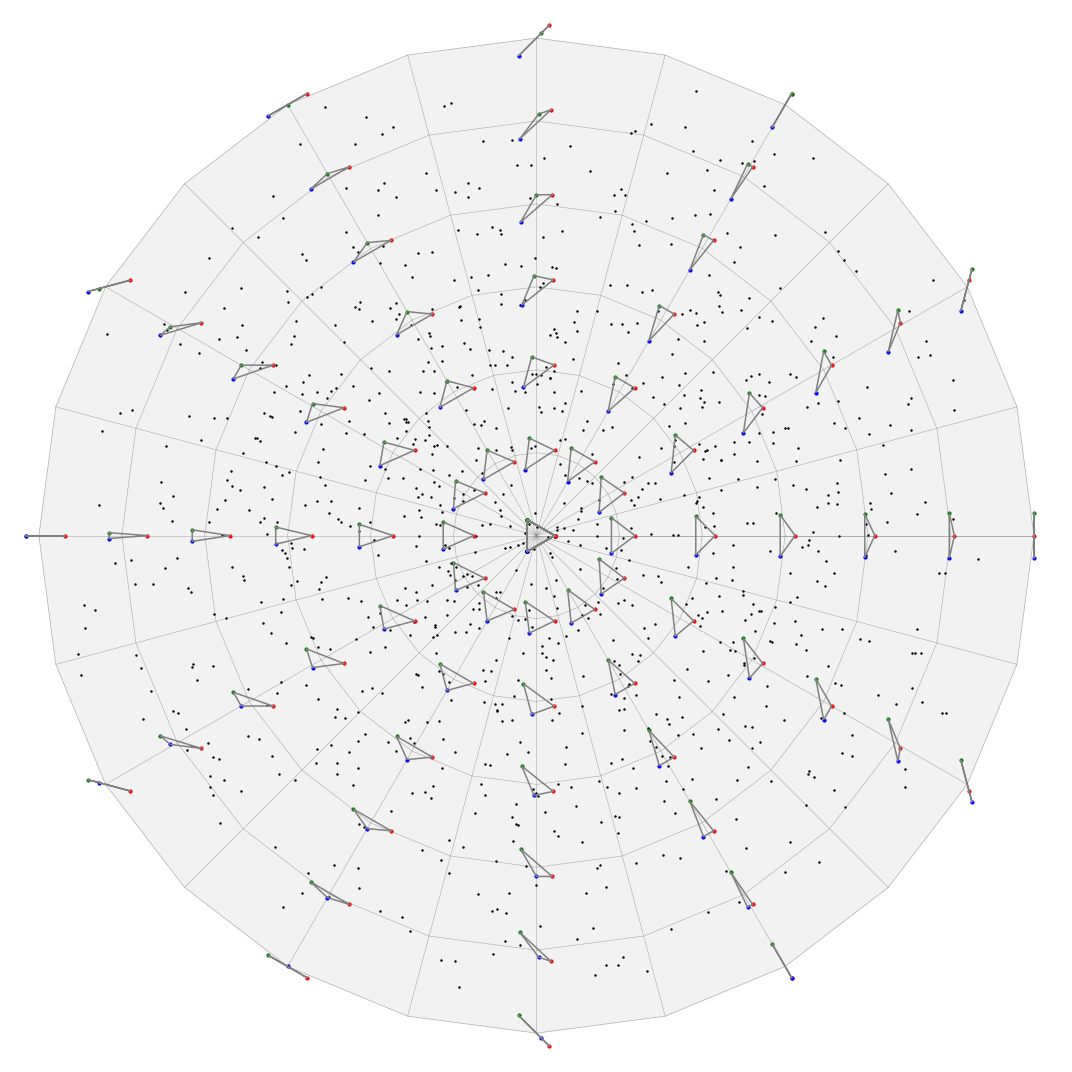

In [14]:
fig = plt.figure(figsize=(15, 15))
D.draw()

points = preshape_triangle_3d.random_uniform(1000)

D.clear_points()
D.add_points(points)
D.draw_points(color='k', s=2)

## Geodesics 

We show a first example where the geodesic is radial. It is the projection of the geodesic we previously shot in $\Sigma^3_2$. 

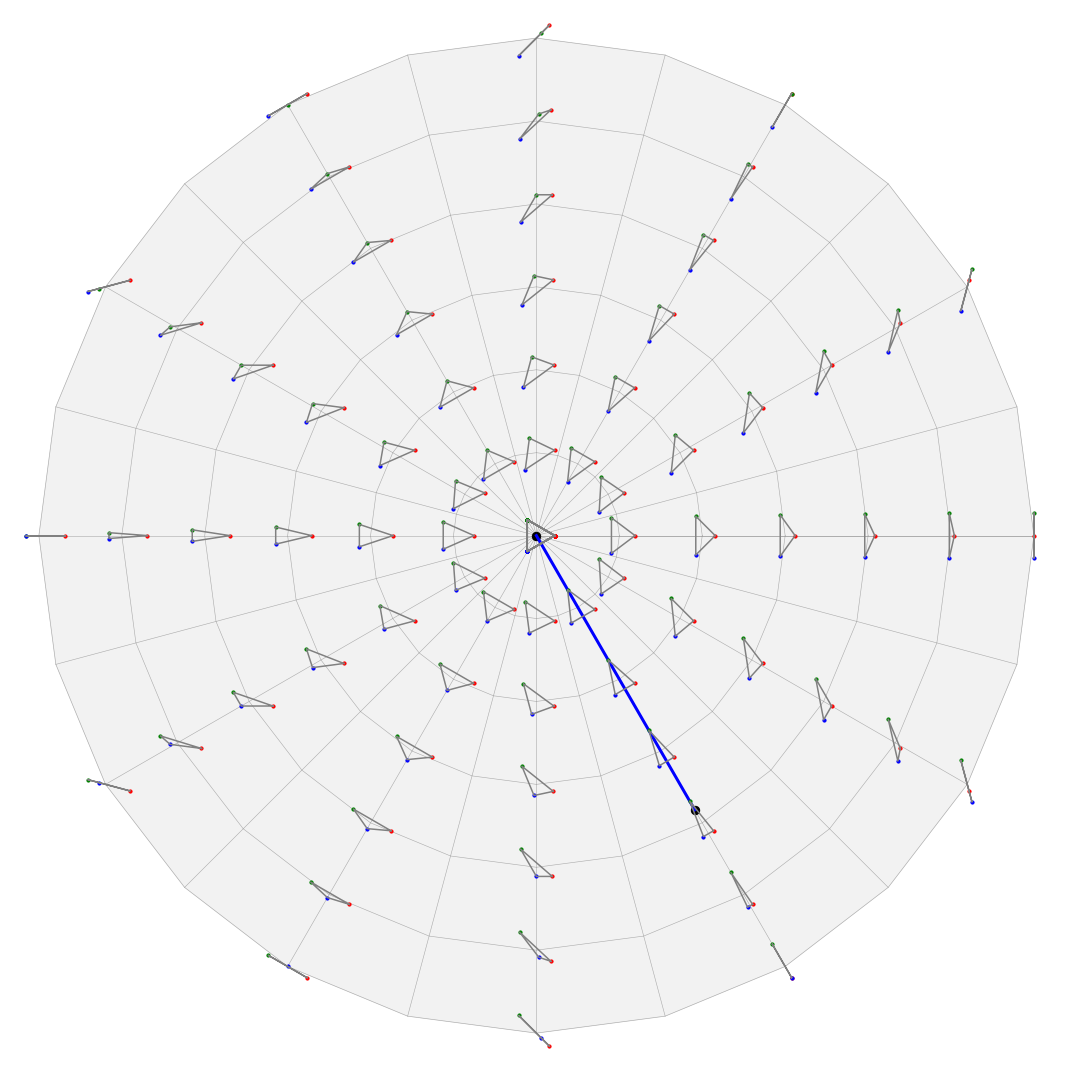

In [15]:
fig = plt.figure(figsize=(15, 15))
D.draw()

times = gs.linspace(0., 1., 1000)
ub_3d = gs.transpose(gs.stack((D.ub[:, 0], D.ub[:, 1], gs.zeros(3))))
speeds = gs.array([-t * .5 * ub_3d for t in times])
points = metric_triangle_3d.exp(speeds, D.centre)

D.clear_points()
D.add_points(points)
D.draw_curve(color='b', lw=3)
D.clear_points()
D.add_points(points[[0, -1]])
D.draw_points(color='k', s=70)

We show a second example where the initial point is no more the equilateral triangle.

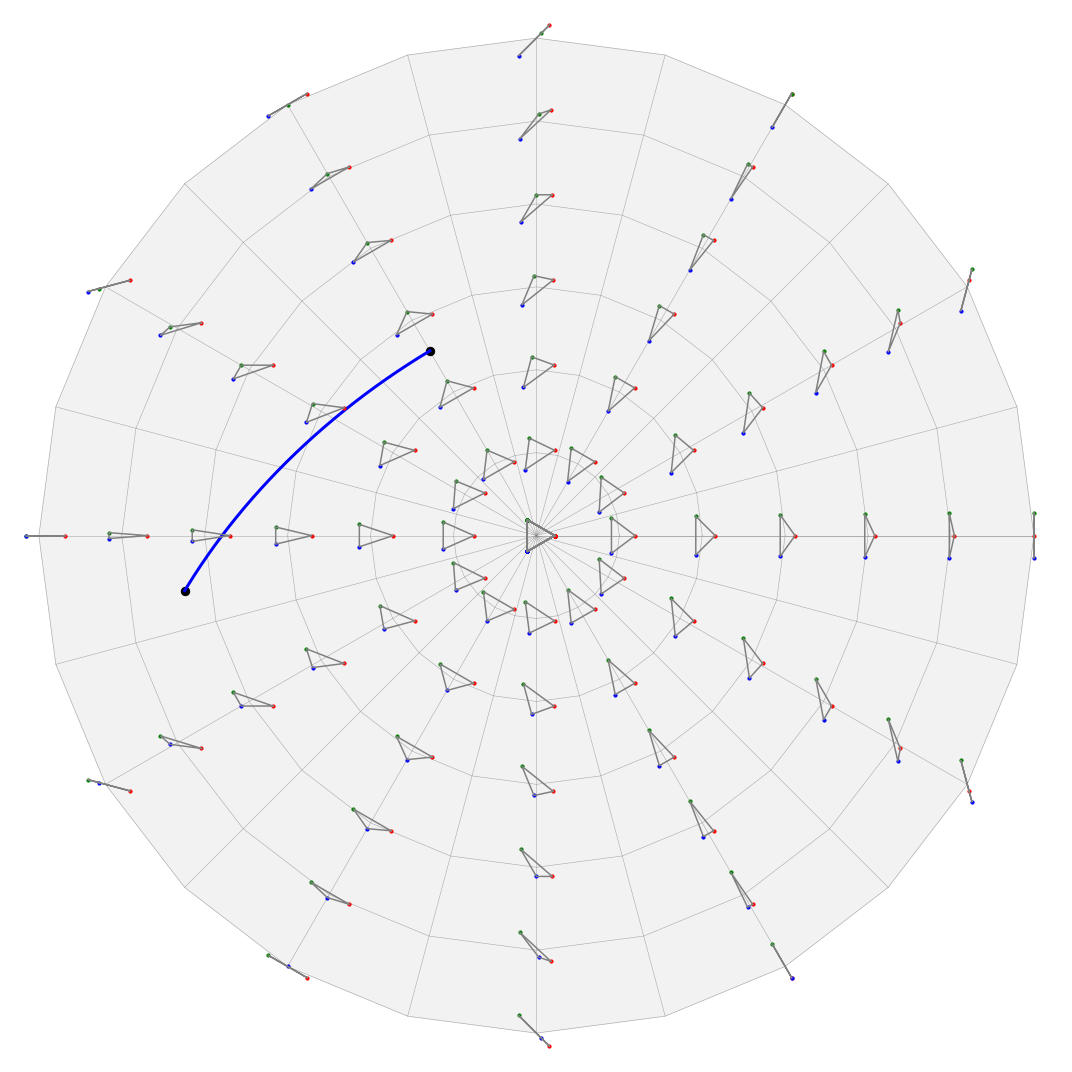

In [29]:
fig = plt.figure(figsize=(15, 15))
D.draw()

times = gs.linspace(0., 1., 1000)
base_point = preshape_triangle_3d.projection(D.centre + .35 * ub_3d)
tangent_vec = preshape_triangle_3d.to_tangent(preshape_triangle_3d.random_point(), base_point)
tangent_vec = .5 * tangent_vec / metric_triangle_3d.norm(tangent_vec, base_point)
speeds = gs.array([t * tangent_vec for t in times])
points = metric_triangle_3d.exp(speeds, base_point)

D.clear_points()
D.add_points(points)
D.draw_curve(color='b', lw=3)
D.clear_points()
D.add_points(points[[0,-1]])
D.draw_points(color='k', s=70)

## Parallel transport 

We compute the parallel transport of an orthogonal vector $w$ along the previous geodesic using the Pole Ladder method.

In [30]:
base_point = base_point
v = tangent_vec
w = preshape_triangle_3d.to_tangent(preshape_triangle_3d.random_point(), base_point)
w = w - metric_triangle_3d.inner_product(w, 2. * tangent_vec, base_point) * 2. * tangent_vec
w = w / metric_triangle_3d.norm(w, base_point)
n_rungs = 10
ladder = metric_triangle_3d.ladder_parallel_transport(
    w, v, base_point, n_rungs, return_geodesics=True)

transported = ladder['transported_tangent_vec']
end_point = ladder['end_point']
trajectory = ladder['trajectory']

n_points = 10
t = gs.linspace(0., 1, n_points)
t_main = gs.linspace(0., 1., n_points * 4)
main = []
diag = []
for points in trajectory:
    main_geodesic, diagonal, final_geodesic = points
    main.append(main_geodesic(t_main))
    diag.append(diagonal(-t))
    diag.append(diagonal(t))

diag = gs.stack(diag).reshape(-1, k_landmarks, m_ambient)
main = gs.stack(main).reshape(-1, k_landmarks, m_ambient)

tangent_vectors = [v / n_rungs, w / n_rungs, transported / n_rungs]
base_points = [base_point, base_point, main[-1]]

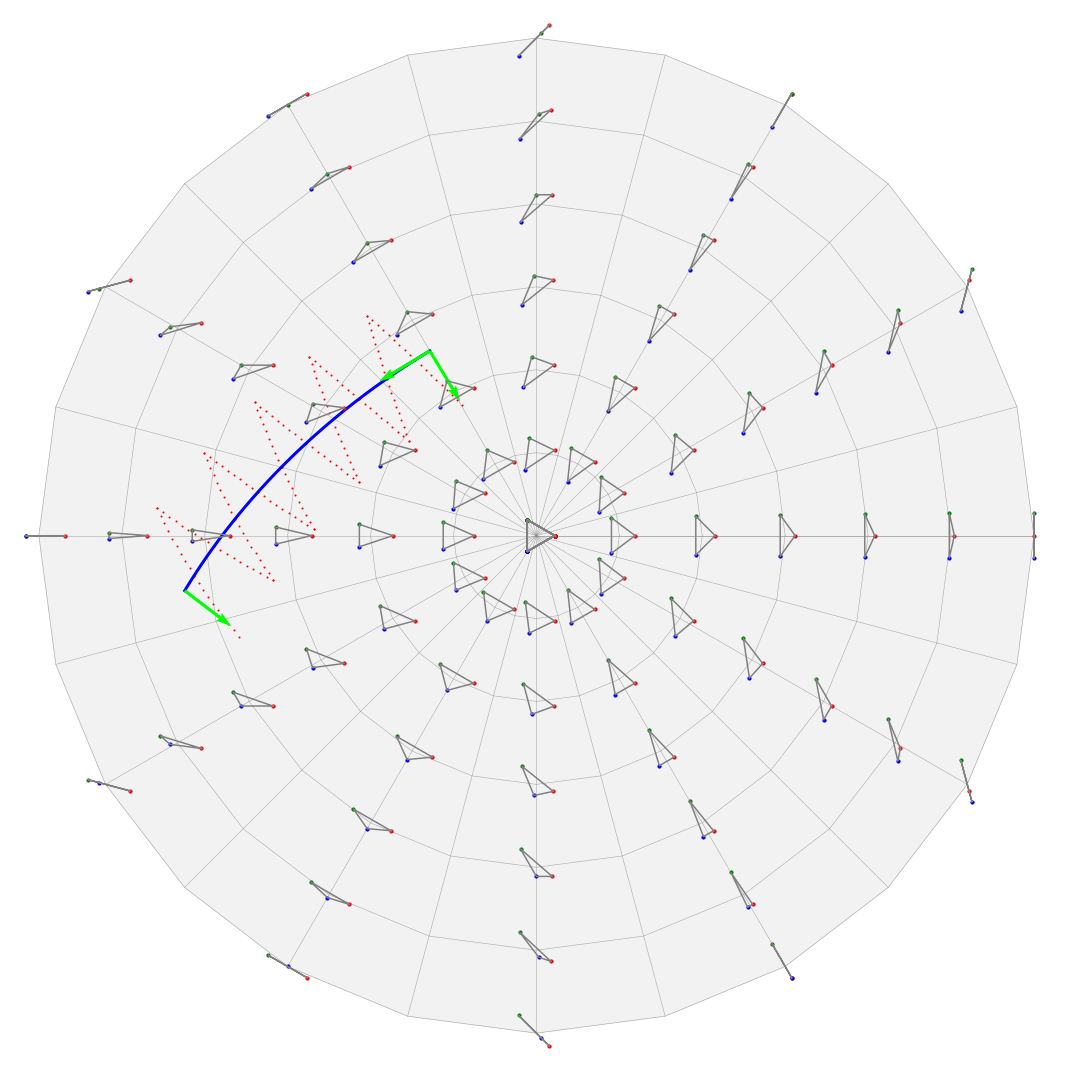

In [31]:
fig = plt.figure(figsize=(15, 15))
D.draw()

D.clear_points()
D.add_points(main)
D.draw_curve(color='b', lw=3)
D.clear_points()
D.add_points(diag)
D.draw_points(color='r', s=1)
for bp, vec in zip(base_points, tangent_vectors):
    D.draw_vector(vec, bp, color=(0, 1, 0), width=.003)

# Usecase : optical nerve heads

In this usecase, we will illustrate how to use this last visualization class while investigating if there is a difference between two groups :

- optical nerve heads that correspond to normal eyes,
- optical nerve heads that correspond to glaucoma eyes.

We import the dataset of the optical nerve heads from 22 images of Rhesus monkeys’ eyes (11 monkeys), available in [PE2015].

For each monkey, an experimental glaucoma was introduced in one eye, while the second eye was kept as control. One seeks to observe differences between the glaucoma and the control eyes. On each image, 5 anatomical landmarks were recorded:

- 1st landmark: superior aspect of the retina,
- 2nd landmark: side of the retina closest to the temporal bone of the skull,
- 3rd landmark: nose side of the retina,
- 4th landmark: inferior point,
- 5th landmark: optical nerve head deepest point.

Label 0 refers to a normal eye, and Label 1 to an eye with glaucoma.

In [19]:
nerves, labels, monkeys = data_utils.load_optical_nerves()
print(nerves.shape)
print(labels)
print(monkeys)

(22, 5, 3)
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10]


For this study we will consider only 3 first landmarks, such that our dataset is now a set of 22 labeled triangles.

In [38]:
landmarks = [0, 1, 2]
data = nerves[:, landmarks, :]

We can visualize the dataset on the disk.

In [39]:
D = KendallDisk(point_type='extrinsic')

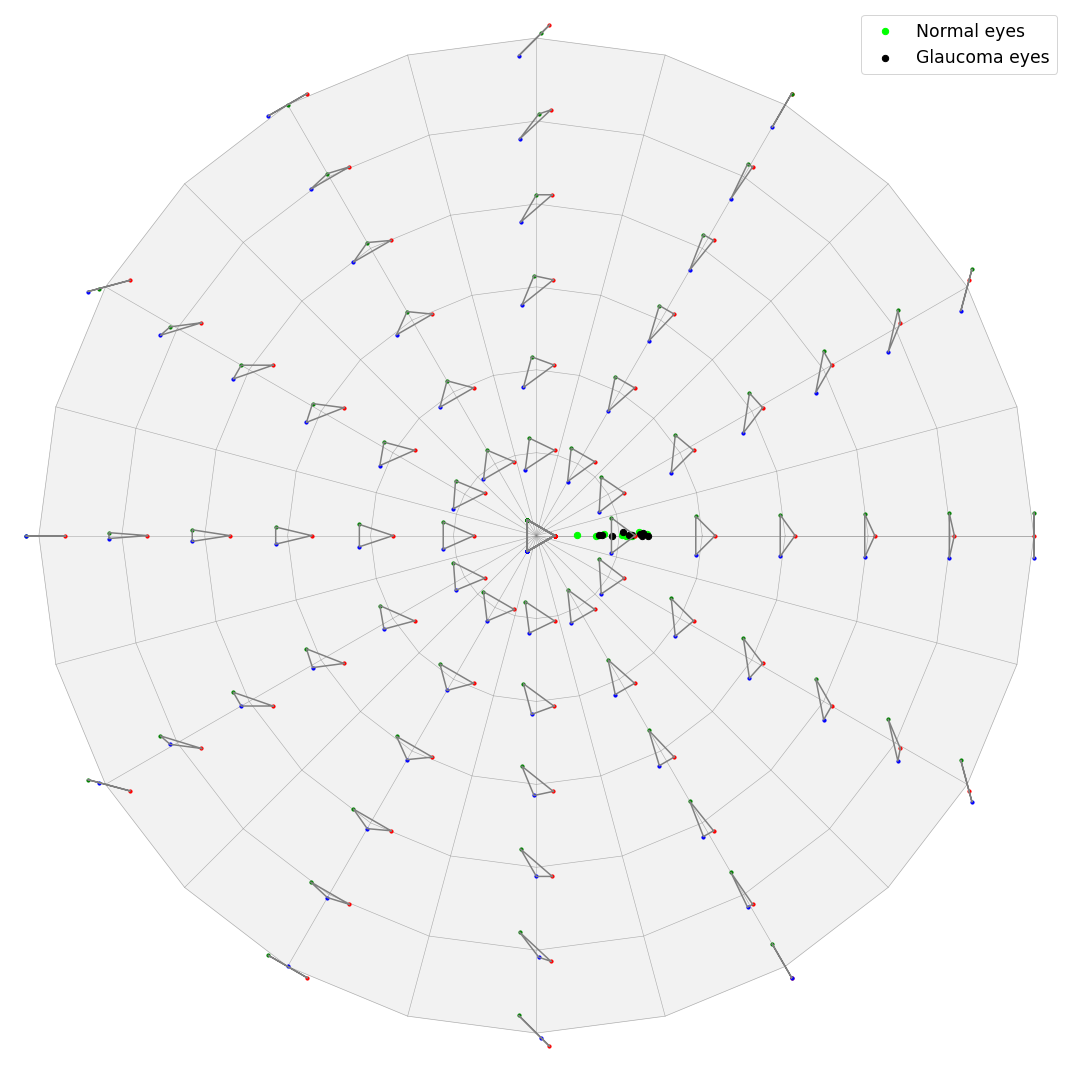

In [40]:
normal_points = gs.array([data[i] for i in range(22) if labels[i] == 0])
glaucoma_points = gs.array([data[i] for i in range(22) if labels[i] == 1])

fig = plt.figure(figsize=(15, 15))
D.draw()

D.add_points(normal_points)
D.draw_points(color=(0, 1, 0), s=40, label='Normal eyes')
D.clear_points()
glaucoma = D.add_points(glaucoma_points)
D.draw_points(color=(0, 0, 0), s=40, label='Glaucoma eyes')

plt.legend(fontsize = 'xx-large')

We observe that the two sets are very compact and well superimposed. It means that this choice of 3 landmarks isn't of any help in separating the two groups. Therfore, we choose to include the 5th landmark into the selection and run a new example.

In [23]:
landmarks = [0, 1, 4]
data = nerves[:, landmarks, :]

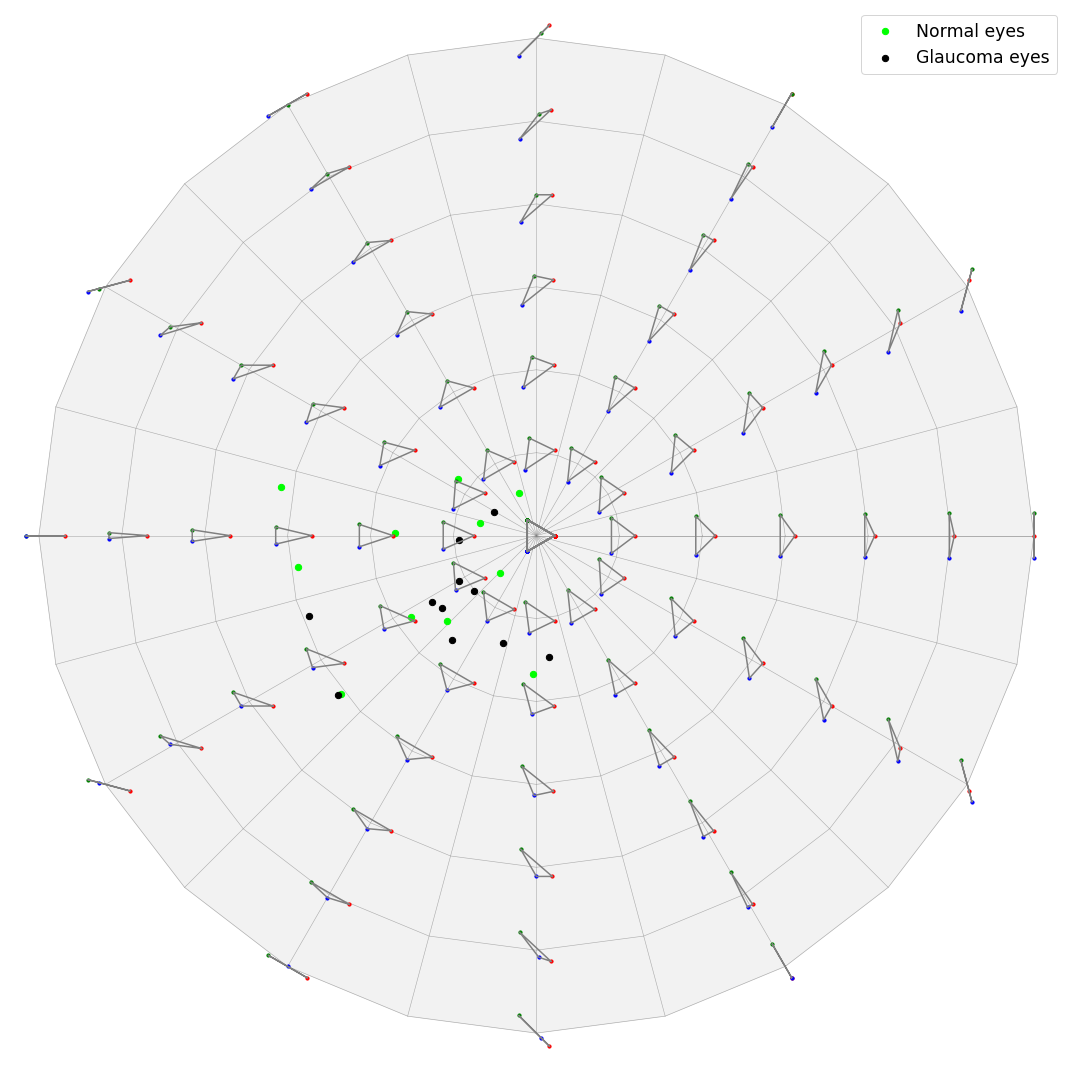

In [33]:
normal_points = gs.array([data[i] for i in range(22) if labels[i] == 0])
glaucoma_points = gs.array([data[i] for i in range(22) if labels[i] == 1])

fig = plt.figure(figsize=(15, 15))
D.draw()

D.clear_points()
D.add_points(normal_points)
D.draw_points(color=(0, 1, 0), s=40, label='Normal eyes')
D.clear_points()
glaucoma = D.add_points(glaucoma_points)
D.draw_points(color=(0, 0, 0), s=40, label='Glaucoma eyes')

plt.legend(fontsize = 'xx-large')

In this example, we observe a bigger variability within the two groups. Even though we can't separate them visually, they are not superimposed either. To highlight this, we can compute the Frechet mean of each group.

In [25]:
from geomstats.learning.frechet_mean import FrechetMean

In [26]:
FM = FrechetMean(metric_triangle_3d)

In [27]:
normal_mean = FM.fit(preshape_triangle_3d.projection(normal_points)).estimate_
glaucoma_mean = FM.fit(preshape_triangle_3d.projection(glaucoma_points)).estimate_

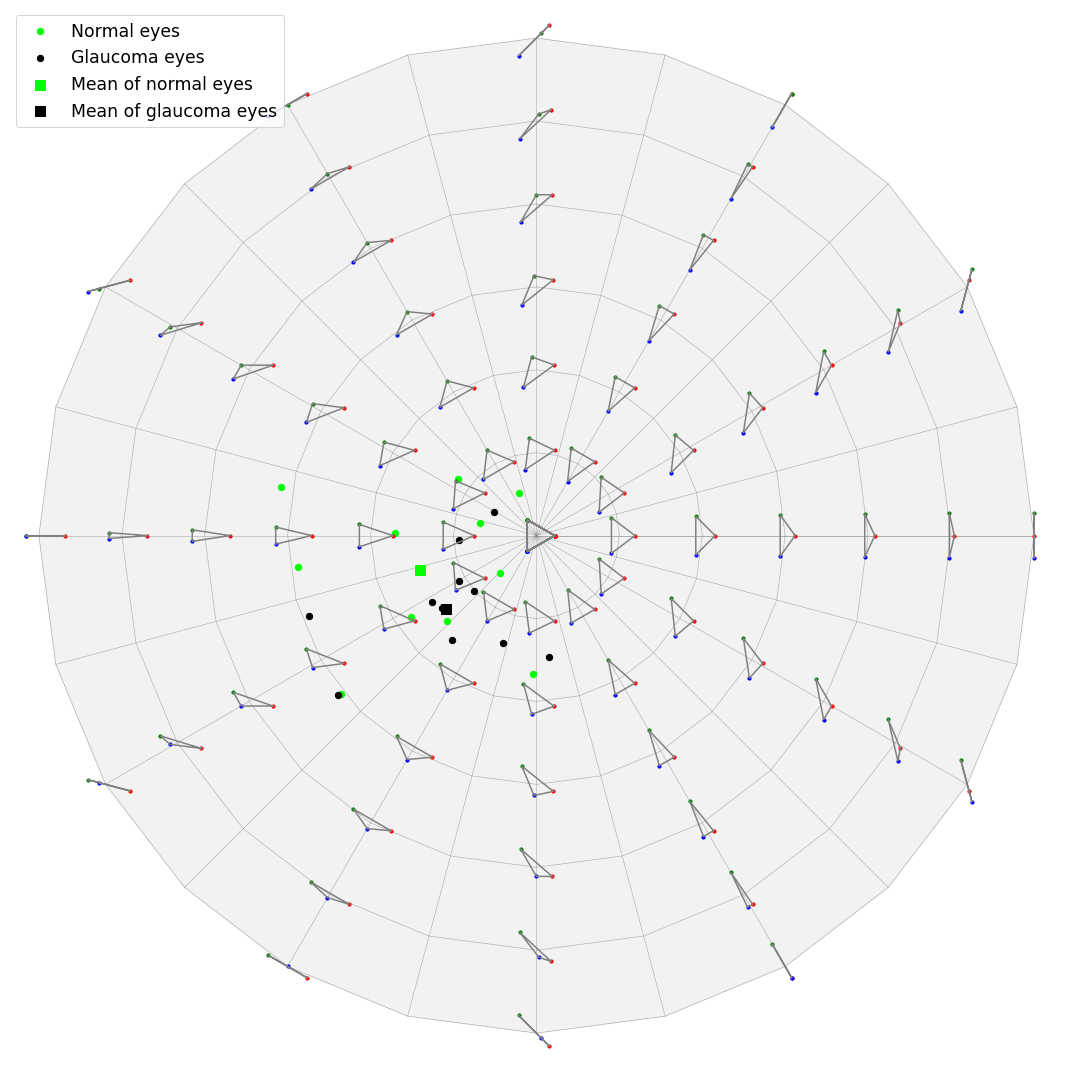

In [36]:
fig = plt.figure(figsize=(15, 15))
D.draw()

D.clear_points()
D.add_points(normal_points)
D.draw_points(color=(0, 1, 0), s=40, label='Normal eyes')
D.clear_points()
glaucoma = D.add_points(glaucoma_points)
D.draw_points(color=(0, 0, 0), s=40, label='Glaucoma eyes')
D.clear_points()
D.add_points(normal_mean)
D.draw_points(color=(0, 1, 0), marker='s', s=100, label='Mean of normal eyes')
D.clear_points()
D.add_points(glaucoma_mean)
D.draw_points(color=(0, 0, 0), marker='s', s=100, label='Mean of glaucoma eyes')

plt.legend(fontsize = 'xx-large')

We observe that the two means are slightly different.

# References

.. [KK1980] KENDALL, David G. et KENDALL, Wilfrid S. 
Alignments in two-dimensional random sets of points. 
Advances in Applied probability, 1980, p. 380-424.
https://doi.org/10.2307/1426603

.. [DM2016] DRYDEN, Ian L. et MARDIA, Kanti V. 
Statistical shape analysis: with applications in R. 
John Wiley & Sons, 2016.
https://doi.org/10.1002/9781119072492

.. [K1984] KENDALL, David G. 
Shape manifolds, procrustean metrics, and complex projective spaces. 
Bulletin of the London mathematical society, 1984, vol. 16, no 2, p. 81-121.
https://doi.org/10.1112/blms/16.2.81

.. [LK1993] LE, Huiling, KENDALL, David G., et al. 
The Riemannian structure of Euclidean shape spaces: a novel environment for statistics. 
Annals of statistics, 1993, vol. 21, no 3, p. 1225-1271.
https://doi.org/10.1112/blms/16.2.81

.. [KDLS2021] KIM, Kwang-Rae, DRYDEN, Ian L., LE, Huiling, SEVERN, Katie E. 
Smoothing splines on Riemannian manifolds, with applications to 3D shape space.
Journal of the Royal Statistical Society: Series B (Statistical Methodology), 2021, vol. 83, no 1, p. 108-132.
https://doi.org/10.1111/rssb.12402

.. [GMTP2021] GUIGUI, Nicolas, MAIGNANT, Elodie, TROUVE, Alain, PENNEC, Xavier. 
Parallel Transport on Kendall Shape Spaces.
5th conference on Geometric Science of Information, Paris 2021. Lecture Notes in Computer Science. Springer, 2021. https://hal.inria.fr/hal-03160677